# A Movie Recommendation System in Python from Scratch

### Importing Libraries

In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors 
from scipy.sparse import csr_matrix

### Loading the data from Amazon

In [3]:
# rating dataset
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
# movie dataset
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
print(f"Number of unique movieId's: {len(ratings['movieId'].unique())}")
print(f"Number of unique users: {len(ratings['userId'].unique())}")

Number of unique movieId's: 9724
Number of unique users: 610


### EDA: User Rating Frequency

In [6]:
user_freq = ratings[['userId','rating']].groupby(['userId']).count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head(5)

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [7]:
user_freq.query(' n_ratings.max() == n_ratings ').head(5)

,userId,n_ratings
413,414,2698


In [8]:
user_freq.query(' n_ratings.min() == n_ratings ').head(5)

,userId,n_ratings
52,53,20
146,147,20
188,189,20
193,194,20
206,207,20


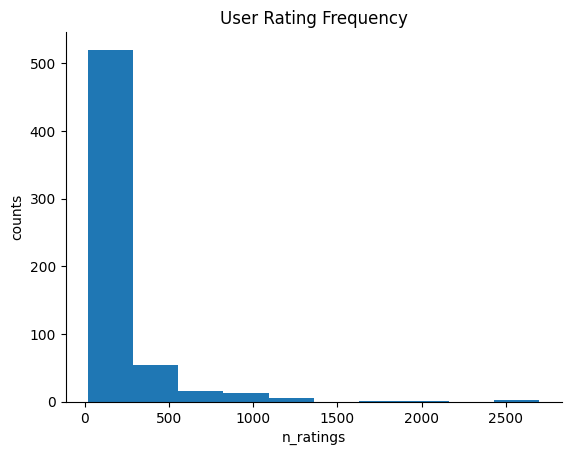

In [9]:
plt.hist(user_freq['n_ratings'])
plt.xlabel('n_ratings')
plt.ylabel('counts')
plt.title('User Rating Frequency')
sns.despine()

## Collaborative Filtering System

Collaborative Filtering recommends items based on similarity measures between users and/or items. The basic assumption behind the algorithm is that users with similar interests have common preferences.

Collaborative filtering uses a **user-item** matrix to generate recommendations. This matrix contains the values that indicate a user’s preference towards a given item. These values can represent either explicit feedback (direct user ratings) or implicit feedback (indirect user behavior such as listening, purchasing, watching).


### User-Item Matrix Creation

In [10]:
X = pd.pivot(ratings, index='movieId', columns='userId', values='rating').fillna(0)
X

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# mappers to be able to map an index of the matrix X back to a movie or user ID
user_index_to_id  = {i:j for i,j in enumerate(X.columns)}
movie_index_to_id = {i:j for i,j in enumerate(X.index)}

user_id_to_index  = {j:i for i,j in enumerate(X.columns)}
movie_id_to_index = {j:i for i,j in enumerate(X.index)}

## Main recommendation code

In [12]:
def recommendation_movie_system(target_movie_id, X, k, metric='cosine'):
    
    # we will store the recommendations in a list named `recommendations`
    recommendations = []
    
    # Map movie_id to movie index to slice matrix X 
    movie_ind = movie_id_to_index[target_movie_id] # this is an index now
    movie_vec = X.values[movie_ind].reshape(1,-1) # this is a vector of shape [1, 610] for the given movie id

    # refine the Uunsupervised learner for implementing neighbor searches
    knn = NearestNeighbors(n_neighbors=k+1, metric=metric).fit(X)
    
    _ , neigh_ind = knn.kneighbors(movie_vec)
    recommendations = [movie_index_to_id[neigh_ind[0][i]] for i in range(k+1)]
    
    # we will pop the first element as this is the same item as the target_movie_id
    recommendations.pop(0)
    
    return recommendations

In [13]:
# Target movie ID in order to find similar movies
target_movie_id = 1
print(f"The title of the target movie id is {movies.query( 'movieId == @target_movie_id' ).title.values[0]}")

get_n_recommendations = 5

similar_movie_ids = recommendation_movie_system(target_movie_id, X, k=get_n_recommendations)

The title of the target movie id is Toy Story (1995)


In [14]:
# mapper of movie id to movie title
movie_titles = dict(zip(movies.movieId, movies.title))

# extract the movie titles of the estimated recommendations
[movie_titles[i] for i in similar_movie_ids]

['Toy Story 2 (1999)',
 'Jurassic Park (1993)',
 'Independence Day (a.k.a. ID4) (1996)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Forrest Gump (1994)']

## Movie Recommendation with respect to Users Preference

In [15]:
def recommend_for_user(target_user_id, X, movie_titles, k=get_n_recommendations):
    
    # get the ratings of this target user
    user_ratings = ratings.query(' userId == @target_user_id ')
    
    # find the movie id with max rating from this user. If many, get the first found
    max_rated_by_target_user = user_ratings.query(' rating == rating.max() ').iloc[0]
    max_movie_id = max_rated_by_target_user['movieId']
    max_movie_title = movie_titles[max_movie_id]
    
    # get recommendations based on the target_movie_id
    similar_movie_ids = recommendation_movie_system(max_movie_id, X, k=k)
    
    print(f"Since you liked a lot {max_movie_title}, you might also like:")
    print(f"\n")

    for movie_ in similar_movie_ids:
        print(movie_titles.get(movie_, "Movie not found"))
    
    return max_movie_id, max_movie_title, similar_movie_ids

In [ ]:
# our target user
target_user_id = 150 

# how many movie recommendations to get
get_n_recommendations = 5

# run the recommendation system for this user
_ ,_ ,_ = recommend_for_user(target_user_id, X, movie_titles, k=get_n_recommendations)

# the end